# Creating a data-backed playing field
Felix Zaussinger | 30.10.2020

## Core Analysis Goal(s)

1. Find LULC GIS layer and download data.
2. Downsampling to ~ 3 lower resolutions/larger cellsizes via rasterio.

## Key Insight(s)

1. The Historical and present land use dataset (downloaded 30.11.2020 at https://hlamap.org.uk/) useful for our purposes. The only thing that is still missing are forests.
2.
3.

## Arising Todo(s)

1. Find forest inventory data and merge with HLA data to get the full picture.

In [1]:
import os
import sys
import logging

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import geopandas as gpd
import rasterio as rio

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Promising data sources for GIS layers are summarised here: https://www.environment.gov.scot/maps/other-map-tools/#land.

These look really cool:

- HabMoS EUNIS Land Cover Scotland (https://map.environment.gov.scot/sewebmap/?layers=eunisLandCoverScotland&extent=-787366,74257,1322365,1708636)
- EUNIS Combined Map (https://hub.jncc.gov.uk/assets/2048c042-5d68-46c6-8021-31d177b00ac4)
- Benchmark LULC data set ( not for free :( ): https://www.ceh.ac.uk/services/land-cover-map-2015
- National Biodiversity Network: https://records.nbnatlas.org/explore/your-area#52.9548|1.1580999999999904|12|ALL_SPECIES
- Historical and present land use (downloaded 30.11.2020): https://hlamap.org.uk/
- Forest inventory and grant eligibility data: https://open-data-scottishforestry.hub.arcgis.com/search?collection=Dataset
- Biosphere Reserves: https://gateway.snh.gov.uk/natural-spaces/dataset.jsp?dsid=BIOSPH
- Geodata in general: https://www.spatialdata.gov.scot/geonetwork/srv/eng/catalog.search#/home

The Historic Land-use Assessment project (HLA) is digitally recording land use across Scotland. It maps both activities like industrial farming or ski areas that are current today, and also land use activities from periods in the past, such as charcoal burning or prehistoric agriculture and settlement. The data has been gathered since 1997 as a partnership between Historic Scotland (HS) and the Royal Commision on the Ancient and Historical Monuments of Scotland and coverage was completed in 2015, a  year that also saw the merging of the two organisations into Historic Environment Scotland.

In [2]:
data_raw = os.path.join("..", "data", "raw")
data_processed = os.path.join("..", "data", "processed")
lulc_fpath = os.path.join(data_raw, "HLAmap", "HLA_Dec2017.shp")

lulc = gpd.read_file(lulc_fpath)
lulc

,TAG,HIS_CODE,REL1_CODE,REL2_CODE,REL3_CODE,Historic_L,Period,Type,Code,Rel1_Cat,Rel1_Per,Rel1_Typ,Rel1_Code_,Rel2_Cat,Rel2_Per,Rel2_Typ,Rel2_Code_,Rel3_Cat,Rel3_Per,Rel3_Typ,Rel3_Code_,SHAPE_Leng,SHAPE_Area,geometry
0,0,0,777,777,777,Water Body,None,Freshwater Area,0,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,633.191560,24484.323235,"POLYGON ((236433.410 541720.530, 236436.010 54..."
1,0,0,777,777,777,Water Body,None,Freshwater Area,0,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,628.802474,19353.320100,"POLYGON ((247970.030 542475.170, 247971.830 54..."
2,0,0,777,777,777,Water Body,None,Freshwater Area,0,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,807.212003,20040.791947,"POLYGON ((237204.270 543089.050, 237204.870 54..."
3,0,0,777,777,777,Water Body,None,Freshwater Area,0,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,568.703642,15701.044600,"POLYGON ((208401.100 543249.570, 208401.890 54..."
4,0,0,777,777,777,Water Body,None,Freshwater Area,0,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,2465.272380,213410.244297,"POLYGON ((236053.580 544007.690, 236052.880 54..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150060,9/115,9,115,777,777,Spiritual and Ritual,19th Century-Present,Monastery or Cathedral,9,"Energy, Extraction and Waste",18th Century-Present,Opencast/Mining/Quarry Site,115,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,3391.850026,148402.497830,"POLYGON ((301824.291 668845.177, 301748.380 66..."
150061,9/116,9,116,777,777,Spiritual and Ritual,19th Century-Present,Monastery or Cathedral,9,Transport,19th Century-Present,Railway Features,116,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,822.336818,16647.726664,"POLYGON ((285931.840 584113.800, 285900.840 58..."
150062,9/122,9,122,777,777,Spiritual and Ritual,19th Century-Present,Monastery or Cathedral,9,Designed Landscape,17th-20th Century,Designed Landscape,122,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1194.723434,76844.711521,"POLYGON ((242048.687 672422.591, 242094.207 67..."
150063,9/122,9,122,777,777,Spiritual and Ritual,19th Century-Present,Monastery or Cathedral,9,Designed Landscape,17th-20th Century,Designed Landscape,122,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,648.628818,21272.730802,"POLYGON ((330274.818 693021.365, 330273.510 69..."


In [3]:
lulc.Period.unique()

array(['None', '18th Century-Present', '18th-19th Century',
       '19th Century-Present', '20th Century-Present',
       'Late 20th Century-Present', '17th-20th Century',
       '18th-20th Century', '19th-20th Century', '20th Century',
       'Medieval/Post-medieval', 'Medieval'], dtype=object)

In [4]:
lulc.Historic_L.unique()

array(['Water Body', 'Agriculture and Settlement', 'Rural Settlement',
       'Built-up Area', 'Woodland and Forestry', 'Leisure and Recreation',
       'Designed Landscape', 'Transport', 'Defence',
       'Energy, Extraction and Waste', 'Spiritual and Ritual',
       'Moorland and Rough Grazing'], dtype=object)

In [5]:
lulc.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

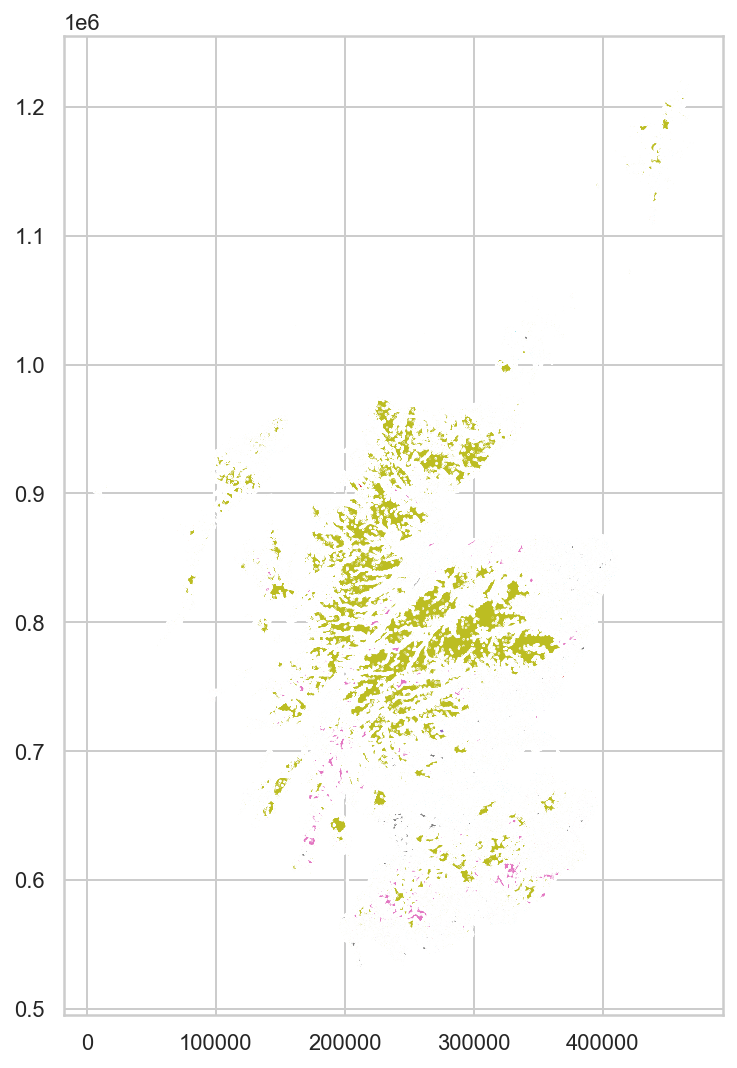

In [6]:
lulc.plot(column="Type")

Subset Galloway and Southern Ayrshire Biosphere Reserve

In [7]:
parks_fpath = os.path.join(data_raw, "BIOSPH_SCOTLAND_ESRI", "BIOSPH_SCOTLAND.shp")
# lulc_park = gpd.clip(lulc, park_polygon)
parks = gpd.read_file(parks_fpath)

In [8]:
parks.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°45'N to 61°N, 9°W to 2°E
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [9]:
parks.crs == lulc.crs

True

In [10]:
our_park = parks.loc[parks.NAME == parks.NAME.unique()[0]]

<AxesSubplot:>

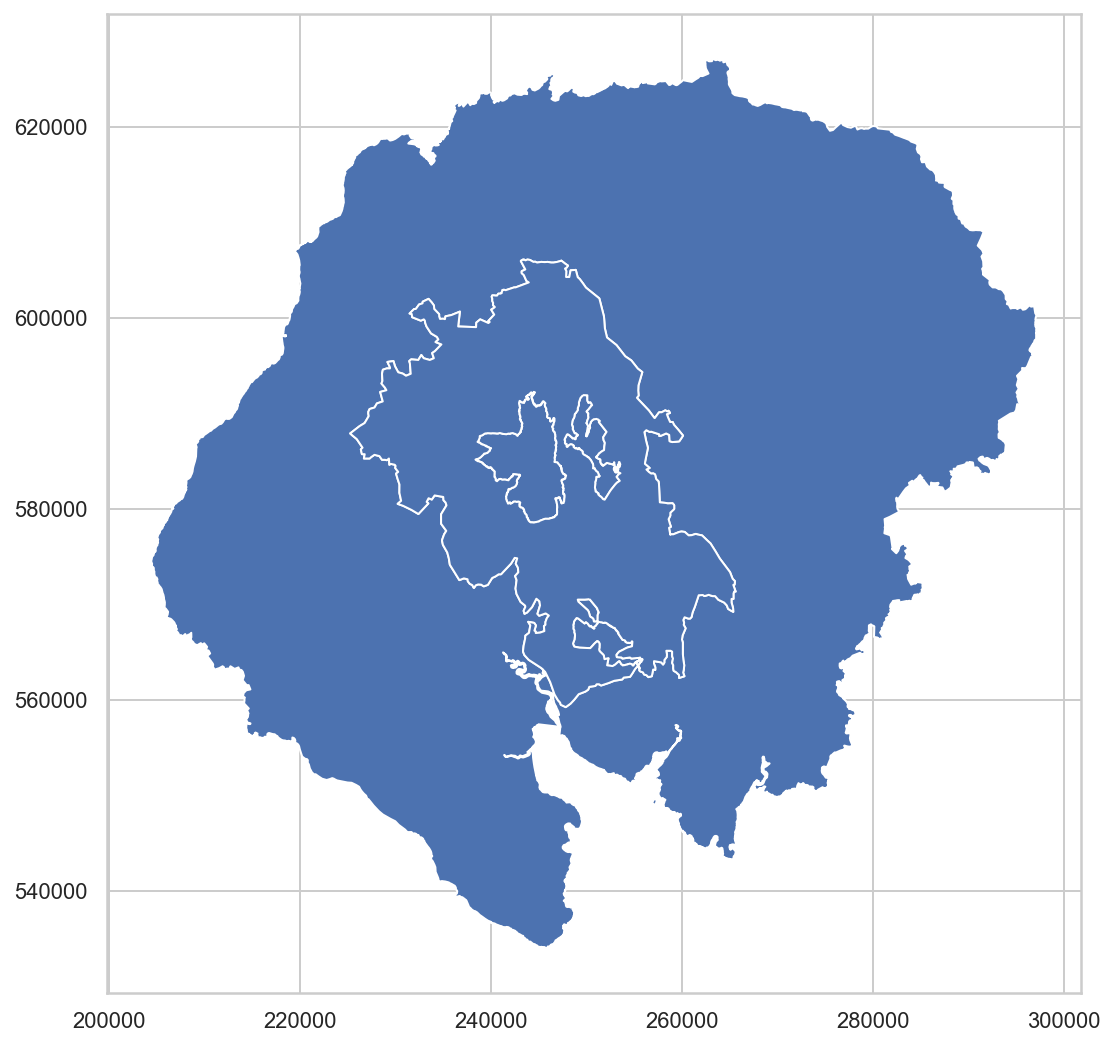

In [11]:
our_park.plot()

<AxesSubplot:>

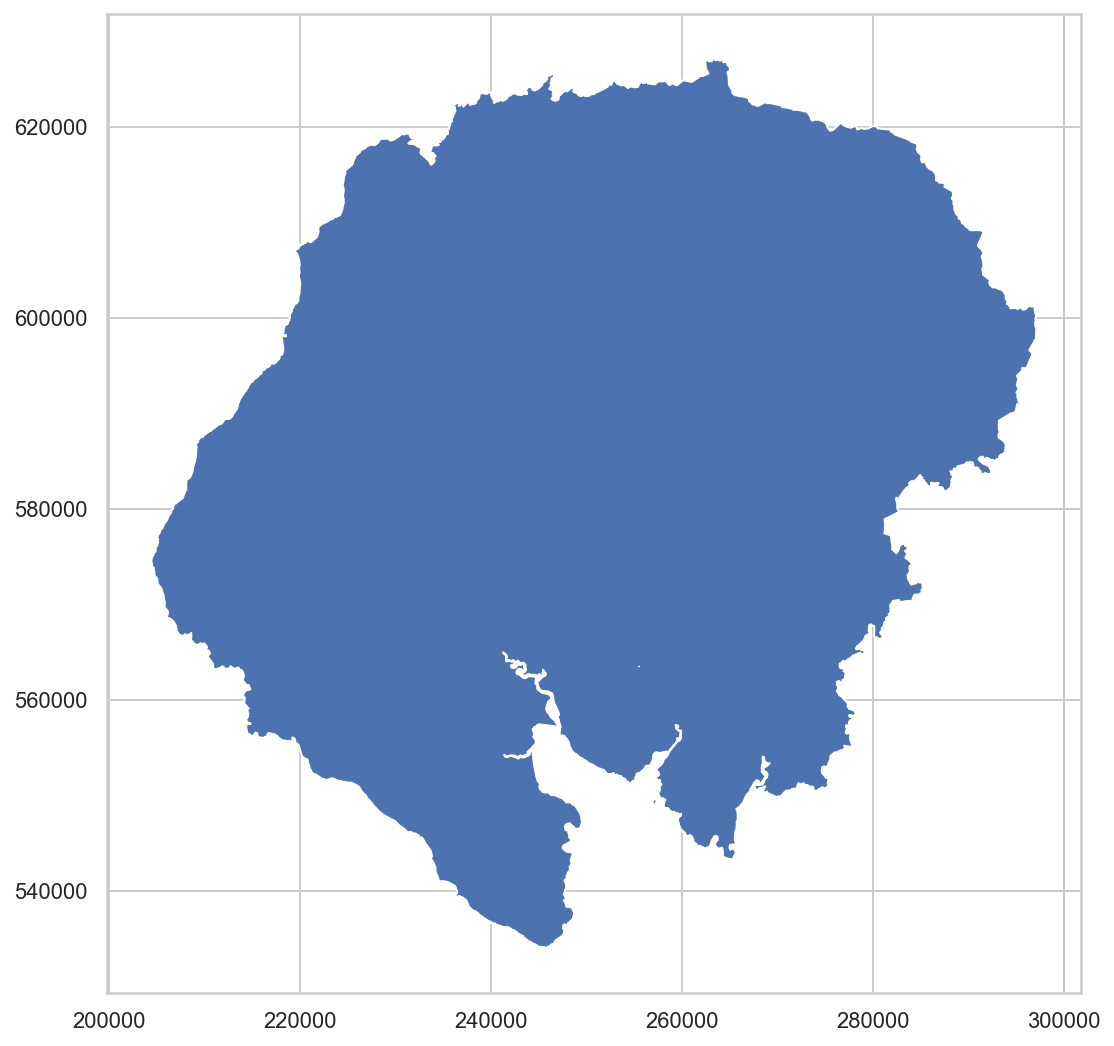

In [12]:
our_park_polygon = our_park.dissolve(by="NAME")
our_park_polygon.plot()

Decision based on https://hlamap.org.uk/pdfs/HLA%20Glossary.pdf

In [13]:
lulc_modern = lulc.loc[lulc.Period == "Late 20th Century-Present"]
lulc_modern_valid = lulc_modern.loc[lulc_modern.is_valid]

INFO:shapely.geos:Ring Self-intersection at or near point 268444.75 669433.91000000015
INFO:shapely.geos:Ring Self-intersection at or near point 277931.93580000009 767368.69629999995
INFO:shapely.geos:Ring Self-intersection at or near point 293872.78120000008 695773.5
INFO:shapely.geos:Ring Self-intersection at or near point 320919.17379999999 696969.01080000028
INFO:shapely.geos:Ring Self-intersection at or near point 224946.43200000003 573504.24300000072
INFO:shapely.geos:Ring Self-intersection at or near point 265948.0175999999 543457.49620000087
INFO:shapely.geos:Ring Self-intersection at or near point 255693.82749999966 564711.53879999928
INFO:shapely.geos:Ring Self-intersection at or near point 327469.6875 577177.81230000034
INFO:shapely.geos:Ring Self-intersection at or near point 260657.15529999975 578437.16019999981
INFO:shapely.geos:Ring Self-intersection at or near point 232157.66509999987 576125.15780000016
INFO:shapely.geos:Ring Self-intersection at or near point 229772.03

,TAG,HIS_CODE,REL1_CODE,REL2_CODE,REL3_CODE,Historic_L,Period,Type,Code,Rel1_Cat,Rel1_Per,Rel1_Typ,Rel1_Code_,Rel2_Cat,Rel2_Per,Rel2_Typ,Rel2_Code_,Rel3_Cat,Rel3_Per,Rel3_Typ,Rel3_Code_,SHAPE_Leng,SHAPE_Area,geometry
54045,15,15,777,777,777,Leisure and Recreation,Late 20th Century-Present,Ski Area,15,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1360.718509,6.865627e+04,"POLYGON ((324413.188 666766.884, 324410.053 66..."
54046,15,15,777,777,777,Leisure and Recreation,Late 20th Century-Present,Ski Area,15,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,6732.910977,4.862367e+05,"POLYGON ((226653.070 752624.350, 226662.760 75..."
54047,15,15,777,777,777,Leisure and Recreation,Late 20th Century-Present,Ski Area,15,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1629.646436,3.710118e+04,"POLYGON ((220000.000 774440.638, 219505.530 77..."
54048,15,15,777,777,777,Leisure and Recreation,Late 20th Century-Present,Ski Area,15,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,6476.829712,1.366748e+06,"POLYGON ((218904.458 775672.370, 218913.983 77..."
54049,15,15,777,777,777,Leisure and Recreation,Late 20th Century-Present,Ski Area,15,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1269.786816,5.498584e+04,"POLYGON ((217429.470 777511.980, 217436.070 77..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142430,5/210,5,210,777,777,Moorland and Rough Grazing,Late 20th Century-Present,Rough Grazing,5,Agriculture and Settlement,Early Prehistoric,Early Prehistoric Settlement and Agriculture -...,210,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1076.885879,7.674131e+04,"POLYGON ((124432.461 763521.066, 124451.948 76..."
142431,5/210,5,210,777,777,Moorland and Rough Grazing,Late 20th Century-Present,Rough Grazing,5,Agriculture and Settlement,Early Prehistoric,Early Prehistoric Settlement and Agriculture -...,210,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,1451.781791,8.850980e+04,"POLYGON ((127261.500 763982.500, 127290.000 76..."
142432,5/210,5,210,777,777,Moorland and Rough Grazing,Late 20th Century-Present,Rough Grazing,5,Agriculture and Settlement,Early Prehistoric,Early Prehistoric Settlement and Agriculture -...,210,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,2312.594249,7.568151e+04,"POLYGON ((411417.312 841516.625, 411417.188 84..."
142433,5/210,5,210,777,777,Moorland and Rough Grazing,Late 20th Century-Present,Rough Grazing,5,Agriculture and Settlement,Early Prehistoric,Early Prehistoric Settlement and Agriculture -...,210,Not Applicable,Not Applicable,Not Applicable,777,Not Applicable,Not Applicable,Not Applicable,777,449.684447,6.018949e+03,"POLYGON ((274616.402 884703.865, 274578.726 88..."


In [14]:
park_modern_lulc = gpd.clip(lulc_modern_valid, our_park_polygon.convex_hull.envelope)

Based on https://stackoverflow.com/questions/54562069/multi-layer-gdb-files-in-python/54563846

In [15]:
# import fiona
# eunis_fpath = os.path.join(data_raw, "C20191101_EUNIS_L3_CombinedMap.gdb")
# eunis = gpd.read_file(eunis_fpath, layer=fiona.listlayers(eunis_fpath)[0])

In [16]:
park_modern_lulc.columns

Index(['TAG', 'HIS_CODE', 'REL1_CODE', 'REL2_CODE', 'REL3_CODE', 'Historic_L',
       'Period', 'Type', 'Code', 'Rel1_Cat', 'Rel1_Per', 'Rel1_Typ',
       'Rel1_Code_', 'Rel2_Cat', 'Rel2_Per', 'Rel2_Typ', 'Rel2_Code_',
       'Rel3_Cat', 'Rel3_Per', 'Rel3_Typ', 'Rel3_Code_', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry'],
      dtype='object')

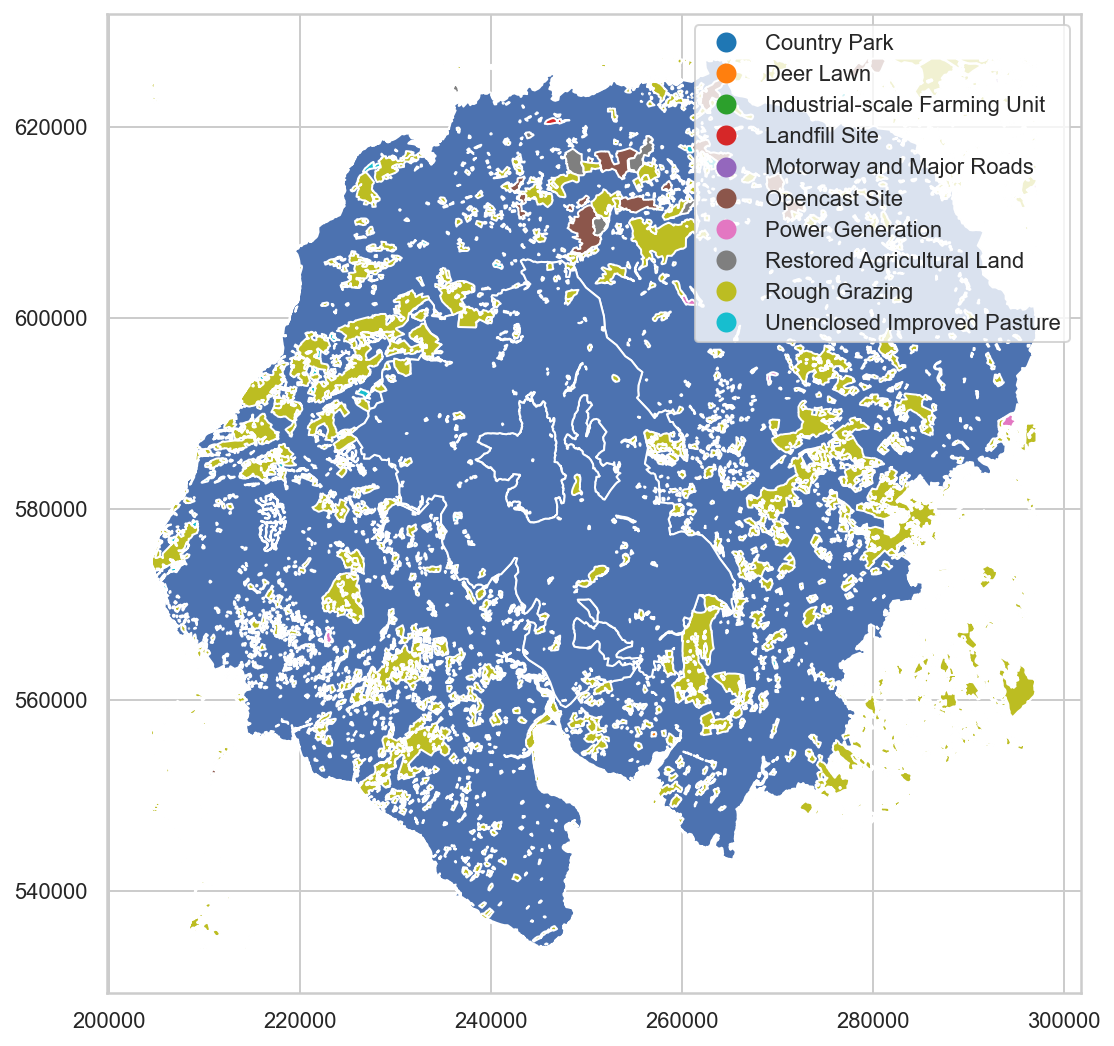

In [134]:
ax = our_park.plot()
park_modern_lulc.plot(
    column = "Type",
    legend = True,
    ax=ax
)

plt.savefig(
    os.path.join(figure_dir, "original_map_forest_missing.png".format(rows, cols)),
    dpi=150,
    format="png"
)

In [18]:
park_modern_lulc.Type.unique()

array(['Country Park', 'Motorway and Major Roads', 'Landfill Site',
       'Opencast Site', 'Industrial-scale Farming Unit',
       'Restored Agricultural Land', 'Unenclosed Improved Pasture',
       'Deer Lawn', 'Power Generation', 'Rough Grazing'], dtype=object)

In [19]:
park_modern_lulc["lulc_type_num"] = 255

https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html

In [20]:
mapping = {
    'Country Park': 1,
    'Motorway and Major Roads': 2,
    'Landfill Site': 3,
    'Opencast Site': 4,
    'Industrial-scale Farming Unit': 5,
    'Restored Agricultural Land': 6,
    'Unenclosed Improved Pasture': 7,
    'Deer Lawn': 8,
    'Power Generation': 9,
    'Rough Grazing': 10
}

In [21]:
park_modern_lulc["lulc_type_num"] = [mapping[k] for k in park_modern_lulc.Type.values]
park_modern_lulc["lulc_type_num"] = park_modern_lulc.lulc_type_num.astype("int16")

#### Polygon to raster

In [61]:
park_modern_lulc.is_valid.value_counts()

True    4387
dtype: int64

array([[   2,    7],
       [   3,    5],
       [   4,   54],
       [   5,   17],
       [   6,   22],
       [   7,   25],
       [   8,    1],
       [   9,   37],
       [  10, 3710],
       [ 255, 4222]])


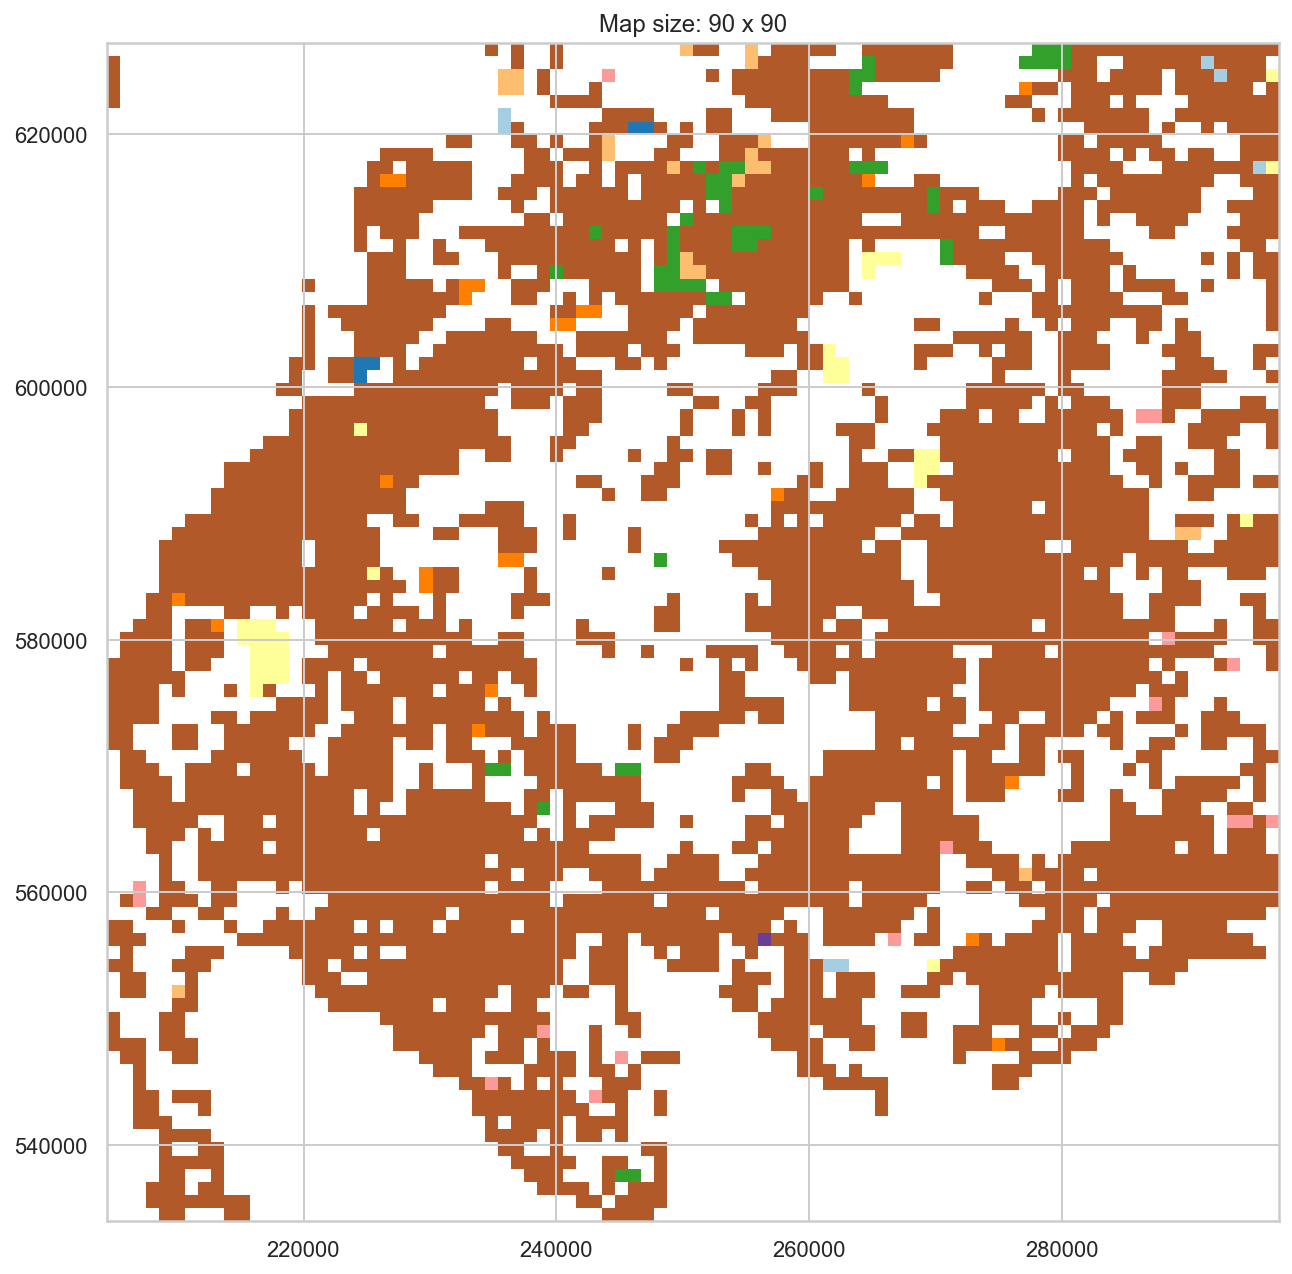

In [140]:
import rasterio
from pprint import pprint
from rasterio import features
from rasterio.plot import show

# raster dims
rows = cols = 90

# transform
bounds = our_park_polygon.convex_hull.envelope.bounds

coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# fpaths
figure_dir = os.path.join("..", "plots")
data_processed = os.path.join("..", "data", "processed")
raster_fpath = os.path.join(data_processed, 'HLA_rasterized_{}_{}.tif'.format(rows, cols))

# burn in
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(park_modern_lulc.geometry, park_modern_lulc.lulc_type_num)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=True
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

# re-read the saved geotiff as a test
src = rasterio.open(raster_fpath)

# read one layer of the map
game_map = src.read(1, masked=True)

# plot resulting map

fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap="Paired")

ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "map_{}_{}.png".format(rows, cols)),
    dpi=150,
    format="png"
)